# Two Towers Model
- based on word2vec embeddings from gensim
- use a simple average of the word embeddings as the document embedding
- use a simple feedforward neural network as the encoder


In [6]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api
from datasets import load_dataset

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import collate
from core import DocumentDataset
from utils.load_data import load_word2vec
from utils.preprocess_str import str_to_tokens, str_to_list


In [7]:
# Define HYPERPARAMETERS
RANDOM_SEED = 42
FREEZE_EMBEDDINGS = True
Q_SEQ_LENGTH = 10
D_SEQ_LENGTH = 400


In [8]:
embeddings, word_to_idx = load_word2vec()
embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=FREEZE_EMBEDDINGS)


In [9]:
df = pd.read_parquet('../data/training.parquet')
# TODO: We should create an ID for each document / query pair — right now they're just for queries ...
df = df.sample(n=10000, random_state=RANDOM_SEED)

In [10]:
df = df[['document', 'query', 'relevance']].copy()
df.reset_index(inplace=True)


In [25]:
df.loc[:, 'document_list_len'] = df['document'].apply(lambda x: len(x.split()))
df.loc[:, 'query_list_len'] = df['query'].apply(lambda x: len(x.split()))


In [27]:
df['document_list_len'].describe()

count    10000.000000
mean        70.673600
std         25.890745
min         11.000000
25%         48.000000
50%         71.000000
75%         91.000000
max        194.000000
Name: document_list_len, dtype: float64

In [28]:
df['document_length'].describe()


count    10000.000000
mean        39.310000
std         13.720981
min          5.000000
25%         28.000000
50%         39.000000
75%         50.000000
max         99.000000
Name: document_length, dtype: float64

In [24]:
len(str_to_tokens(df.loc[10, 'document'], word_to_idx))


32

In [13]:
df.loc[:, 'document_tokens'] = df['document'].apply(lambda x: str_to_tokens(x, word_to_idx))
df.loc[:, 'query_tokens'] = df['query'].apply(lambda x: str_to_tokens(x, word_to_idx))


In [14]:
df.head()

,index,document,query,relevance,document_tokens,query_tokens
0,543005,10 years is not old for a boiler. Ask the serv...,what is fluoxetine used for,0,"[1133, 15, 236, 16348, 919, 51015, 1013, 16348...","[1133, 28114, 10, 1134]"
1,1119141,Gabapentin is a generic for neurontin. Vicodin...,is neurontin a narcotic medication,1,"[1133, 50959, 26, 66519, 51012, 26337, 2244, 8...","[1133, 66519, 7072, 842, 1134]"
2,1402220,What To Expect After Surgery. The hospital sta...,keflex medication uses,0,"[1133, 884, 3779, 1987, 1604, 73704, 716, 43, ...","[1133, 842, 10, 1134]"
3,1366415,"The result, a lot of the time, is a lost carp!...",can you use a chod rig without lead core,1,"[1133, 114, 2132, 14, 606, 12552, 861, 137, 23...","[1133, 10, 65289, 7672, 248, 288, 1845, 1134]"
4,13131,Removing or filling in a wood or steel walled ...,cost to fill in a pool,1,"[1133, 731, 1691, 1477, 1875, 1031, 12357, 309...","[1133, 786, 1691, 3095, 1134]"


In [15]:
df['query_length'] = df['query_tokens'].apply(len)
df['document_length'] = df['document_tokens'].apply(len)



SEQ_LENGTH: ~9


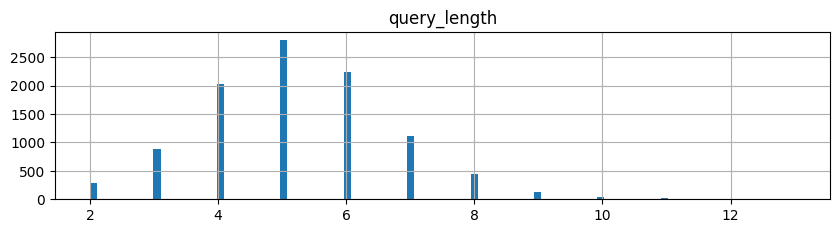

In [20]:
df[['query_length']].hist(bins=100, layout=(2,1 ), figsize=(10, 5))
print('SEQ_LENGTH: ~10')


array([[<Axes: title={'center': 'document_length'}>],
       [<Axes: >]], dtype=object)

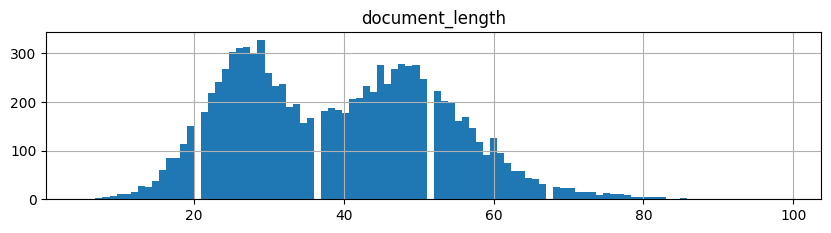

In [21]:
df[['document_length']].hist(bins=100, layout=(2,1 ), figsize=(10, 5))



In [53]:
def embed_tokens(tokens):
    embed_tensor = [torch.tensor(embedding_layer(torch.tensor(t, dtype=torch.long)), dtype=torch.float32) for t in tokens]
    embed_tensor = torch.stack(embed_tensor)
    return embed_tensor



In [65]:

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)


In [67]:
dataset = DocumentDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate)

In [ ]:
i = 0
for docs, queries, doc_mask, query_mask, labels in dataloader:
    print('Batch', i + 1)
    print("Documents shape:", docs.shape)
    print("Queries shape:", queries.shape)
    print("Document mask shape:", doc_mask.shape)
    print("Query mask shape:", query_mask.shape)
    print("Labels shape:", labels.shape)
    print(docs)
    i += 1
    if i > 3:
        break  # Just print the first batch


In [93]:
class TwoTowerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, embedding_layer):
        super(TwoTowerModel, self).__init__()
        
        self.embedding = embedding_layer

        self.doc_rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.query_rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
    
    def doc_forward(self, doc_ids):
        pass
    def query_forward(self, query_ids):
        pass
        
    
    def forward(self, doc_ids, query_ids):
        # do we need to zero out the hidden state?
        doc_embed = self.embedding(doc_ids)
        query_embed = self.embedding(query_ids)

        _, doc_hidden = self.doc_rnn(doc_embed)
        _, query_hidden = self.query_rnn(query_embed)

        doc_encoded = doc_hidden[-1] # average across timesteps
        query_encoded = query_hidden[-1]
        
        similarity = F.cosine_similarity(doc_encoded, query_encoded, dim=1)

        return similarity

    # Loss
        # s = cosine_similarity(hd_n, hq_n)
        # if relevance == 0, s should be low
        # if relevance == 1 or 2, s should be high
        
    # Backprop


In [94]:
model = TwoTowerModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, num_layers=1, embedding_layer=embedding_layer)

In [ ]:
print(model)

In [ ]:
model.eval()

In [ ]:
dataiter = iter(dataloader)
docs, queries, doc_mask, query_mask, labels = next(dataiter)

print(docs.shape)
print(queries.shape)
print(doc_mask.shape)
print(query_mask.shape)
print(labels.shape)

In [98]:
doc = docs[0].unsqueeze(0)
query = queries[0].unsqueeze(0)

In [99]:
with torch.no_grad():
    similarity = model(doc, query)

In [ ]:

print("Input document shape:", doc.shape)
print("Input query shape:", query.shape)
print("Output similarity:", similarity.item())

# If you want to see the actual document and query
print("\nDocument tokens:", doc.squeeze().tolist())
print("Query tokens:", query.squeeze().tolist())

# If you have a way to convert token IDs back to words, you could use it here
# print("Document:", convert_ids_to_words(doc.squeeze().tolist()))
# print("Query:", convert_ids_to_words(query.squeeze().tolist()))

print("\nTrue label:", labels[0].item())